In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
from nilearn import plotting

In [2]:
import nibabel as nib
import numpy as np

In [3]:
from xml.etree import ElementTree

In [4]:
#Load one subject

t1w_im = nib.load('../../data_local/HCP/100206/T1w/T1w_acpc_dc_restore_brain.nii.gz')
labels_im = nib.load('../../data_local/HCP/100206/T1w/aparc.a2009s+aseg.nii.gz')

In [5]:
#Get the label names and colors from the header extension

extension_header = ElementTree.fromstring(
    labels_im.header.extensions[0].get_content()
)

labeltable = {
    l.text: int(l.get('Key'))
    for l in extension_header.findall(".//Label")
}

label_colors = {
    int(l.get('Key')): tuple(
        float(l.get(c))
        for c in ('Red', 'Green', 'Blue')
    )
    for l in extension_header.findall(".//Label")
}

labels = labels_im.get_data()

destrieux_cm = mpl.colors.ListedColormap(
    np.array([
        label_colors.get(i, (0., 0., 0.))
        for i in range(max(label_colors) + 1)
    ]),
    name='Destrieux'
)

/home/tom/.local/miniconda/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


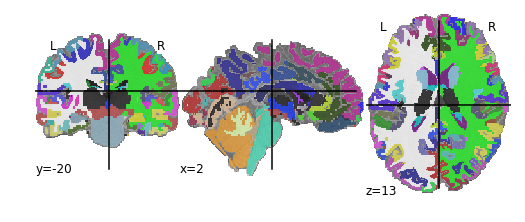

In [6]:
plotting.plot_roi(
    roi_img=labels_im,
    bg_img=t1w_im,
    cmap=destrieux_cm, 
    black_bg=False,
    vmin=0, vmax=max(label_colors) + 1
)

In [7]:
#Filtering only the labels that are Sulci, our goal for detection

sulci_labels = {
    k: v
    for k, v in labeltable.items()
    if '_S_' in k and '_G_' not in k
}
sulci_labels

{'CTX_LH_S_CALCARINE': 11145,
 'CTX_LH_S_CENTRAL': 11146,
 'CTX_LH_S_CINGUL-MARGINALIS': 11147,
 'CTX_LH_S_CIRCULAR_INSULA_ANT': 11148,
 'CTX_LH_S_CIRCULAR_INSULA_INF': 11149,
 'CTX_LH_S_CIRCULAR_INSULA_SUP': 11150,
 'CTX_LH_S_COLLAT_TRANSV_ANT': 11151,
 'CTX_LH_S_COLLAT_TRANSV_POST': 11152,
 'CTX_LH_S_FRONT_INF': 11153,
 'CTX_LH_S_FRONT_MIDDLE': 11154,
 'CTX_LH_S_FRONT_SUP': 11155,
 'CTX_LH_S_INTERM_PRIM-JENSEN': 11156,
 'CTX_LH_S_INTRAPARIET_AND_P_TRANS': 11157,
 'CTX_LH_S_OC_MIDDLE_AND_LUNATUS': 11158,
 'CTX_LH_S_OC_SUP_AND_TRANSVERSAL': 11159,
 'CTX_LH_S_OCCIPITAL_ANT': 11160,
 'CTX_LH_S_OC-TEMP_LAT': 11161,
 'CTX_LH_S_OC-TEMP_MED_AND_LINGUAL': 11162,
 'CTX_LH_S_ORBITAL_LATERAL': 11163,
 'CTX_LH_S_ORBITAL_MED-OLFACT': 11164,
 'CTX_LH_S_ORBITAL-H_SHAPED': 11165,
 'CTX_LH_S_PARIETO_OCCIPITAL': 11166,
 'CTX_LH_S_PERICALLOSAL': 11167,
 'CTX_LH_S_POSTCENTRAL': 11168,
 'CTX_LH_S_PRECENTRAL-INF-PART': 11169,
 'CTX_LH_S_PRECENTRAL-SUP-PART': 11170,
 'CTX_LH_S_SUBORBITAL': 11171,
 'CTX_LH_S

In [8]:
sulci_masks = np.zeros_like(labels_im.get_data(), dtype=np.int32)
for label in sulci_labels.values():
    mask = (labels == label)
    sulci_masks[mask] = label

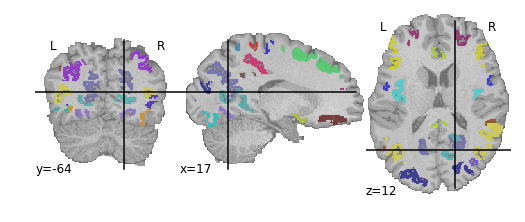

In [9]:
plotting.plot_roi(
    nib.spatialimages.SpatialImage(sulci_masks, labels_im.affine),
    bg_img=t1w_im,
    cmap=destrieux_cm,
    black_bg=False, vmin=0, vmax=max(label_colors) + 1
)

In [39]:
subject = '100206'

t1w_im = nib.load('../../data_local/HCP/100206/T1w/T1w_acpc_dc_restore_brain.nii.gz')
labels_im = nib.load('../../data_local/HCP/100206/T1w/aparc.a2009s+aseg.nii.gz')


def _replace_label(labels_data, labels_grouping):
    new_labels = np.empty(labels_data.shape, dtype=int)
    for label, group in labels_grouping.items():
        new_labels[labels_data == label] = group
    return new_labels


TIER_PATTERNS = {
    1: ['S_CENTRAL',
        'LAT_FIS-POST',
        'LAT_FIS-ANT-HORIZONT',
        'LAT_FIS-ANT-VERTICAL',
        'S_PERICALLOSAL',
        'S_PARIETO_OCCIPITAL',
        'S_CALCARINE',
        'G_POSTCENTRAL',
        'G_CUNEUS',
        'G_FRONT_SUP',
        'G_PRECENTRAL',
    ],
    2: ['S_SUBPARIETAL',
        'S_PRECENTRAL-INF-PART',
        'S_PRECENTRAL-SUP-PART',
        'S_POSTCENTRAL',
        'S_TEMPORAL_SUP',
        'S_FRONT_SUP',
    ],
    3: ['S_OCCIPITAL_ANT',
        'S_OC_MIDDLE_AND_LUNATUS',
    ]
}

def get_tier(label):
    for tier, patterns in TIER_PATTERNS:
        for pattern in patterns:
            if pattern in label:
                return tier
    return 4
        
    for pattern in TIER_2_PATTERNS:
        if pattern in label:
            return 2
    return 3


TIER_MAP = {
    k: get_tier(k) for k in labeltable
}
TIER_MAP['???'] = 0

mask = _replace_label(labels_im, TIER_MAP)

tier1_masks = np.zeros_like(labels_im.get_data(), dtype=np.int32)
labels = labels_im.get_data()
for label, tier in TIER_MAP.items():
    if tier in [1, 2]:
        mask = (labels == labeltable[label])
        tier1_masks[mask] = labeltable[label]

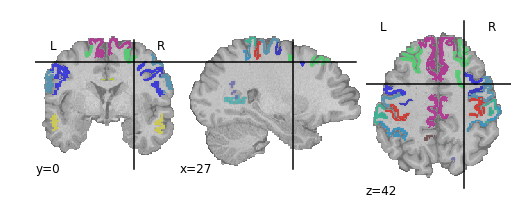

In [40]:
%matplotlib inline
plotting.plot_roi(
    nib.spatialimages.SpatialImage(tier1_masks, labels_im.affine),
    bg_img=t1w_im,
    cmap=destrieux_cm,
    black_bg=False, vmin=0, vmax=max(label_colors) + 1
)

In [36]:
list(TIER_1_GROUP)

['???',
 'LEFT-CEREBRAL-WHITE-MATTER',
 'LEFT-LATERAL-VENTRICLE',
 'LEFT-INF-LAT-VENT',
 'LEFT-CEREBELLUM-WHITE-MATTER',
 'LEFT-CEREBELLUM-CORTEX',
 'LEFT-THALAMUS-PROPER',
 'LEFT-CAUDATE',
 'LEFT-PUTAMEN',
 'LEFT-PALLIDUM',
 '3RD-VENTRICLE',
 '4TH-VENTRICLE',
 'BRAIN-STEM',
 'LEFT-HIPPOCAMPUS',
 'LEFT-AMYGDALA',
 'CSF',
 'LEFT-ACCUMBENS-AREA',
 'LEFT-VENTRALDC',
 'LEFT-VESSEL',
 'LEFT-CHOROID-PLEXUS',
 'RIGHT-CEREBRAL-WHITE-MATTER',
 'RIGHT-LATERAL-VENTRICLE',
 'RIGHT-INF-LAT-VENT',
 'RIGHT-CEREBELLUM-WHITE-MATTER',
 'RIGHT-CEREBELLUM-CORTEX',
 'RIGHT-THALAMUS-PROPER',
 'RIGHT-CAUDATE',
 'RIGHT-PUTAMEN',
 'RIGHT-PALLIDUM',
 'RIGHT-HIPPOCAMPUS',
 'RIGHT-AMYGDALA',
 'RIGHT-ACCUMBENS-AREA',
 'RIGHT-VENTRALDC',
 'RIGHT-VESSEL',
 'RIGHT-CHOROID-PLEXUS',
 'WM-HYPOINTENSITIES',
 'NON-WM-HYPOINTENSITIES',
 'OPTIC-CHIASM',
 'CC_POSTERIOR',
 'CC_MID_POSTERIOR',
 'CC_CENTRAL',
 'CC_MID_ANTERIOR',
 'CC_ANTERIOR',
 'CTX-LH-UNKNOWN',
 'CTX-RH-UNKNOWN',
 'CTX_LH_G_AND_S_FRONTOMARGIN',
 'CTX_LH_G_AND

In [1]:
import torch
from segmentation.unet import Unet

In [2]:
unet = Unet(4)

In [3]:
unet.load_state_dict(torch.load('results/model_saved.pth', map_location='cpu'))

In [ ]:
from segmentation.unet import test_full_img
res = test_full_img(unet, '100206', patch_size=16)